In [1]:
%reload_ext eradiate.notebook.tutorials

*Last updated: 2025-08-27 14:22 (eradiate v0.31.0.dev1)*

In [2]:
import eradiate
import matplotlib.pyplot as plt
import mitsuba as mi
import numpy as np

from eradiate import KernelContext
from eradiate.experiments import AtmosphereExperiment
from eradiate.kernel import SceneParameter, SearchSceneParameter
from eradiate.xarray.interp import dataarray_to_rgb

In [3]:
eradiate.set_mode("mono")

In [4]:
surface = None  # Suppress the default surface: we will add our own
atmosphere = {"type": "molecular"}
illumination = {"type": "directional"}
camera = {  # Nadir-looking camera at 3 m altitude
    "type": "perspective",
    "origin": [0, 0, 3],
    "target": [0, 0, 0],
    "up": [0, 1, 0],
    "film_resolution": (128, 128),
    "srf": {"type": "delta", "wavelengths": 550.0},
}

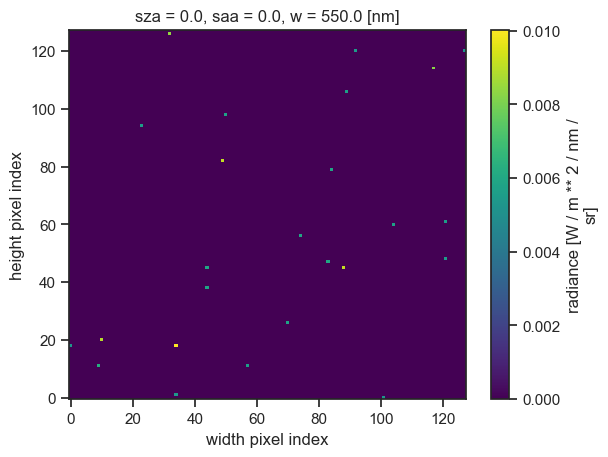

In [5]:
exp = AtmosphereExperiment(
    surface=surface,
    atmosphere=atmosphere,
    illumination=illumination,
    measures=camera,
)
eradiate.run(exp)["radiance"].squeeze().plot.imshow();

In [6]:
kdict={
    # We use numerical prefixes in object IDs to emphasize sectioning and 
    # ordering.
    
    # First, materials (i.e. surface scattering models).
    # The 'id' field of this material must be defined because we reference it 
    # later in the geometric shape definition. It is best to keep it consistent 
    # with the material's dictionary key.
    "01_mat_diffuse": {"type": "diffuse", "id": "01_mat_diffuse"},
    
    # Then, the geometric shape (the [-1, 1]² square).
    # The previously defined material is referenced by its ID.
    "02_shape_square": {
        "type": "rectangle",
        "bsdf": {"type": "ref", "id": "01_mat_diffuse"},
    },
}

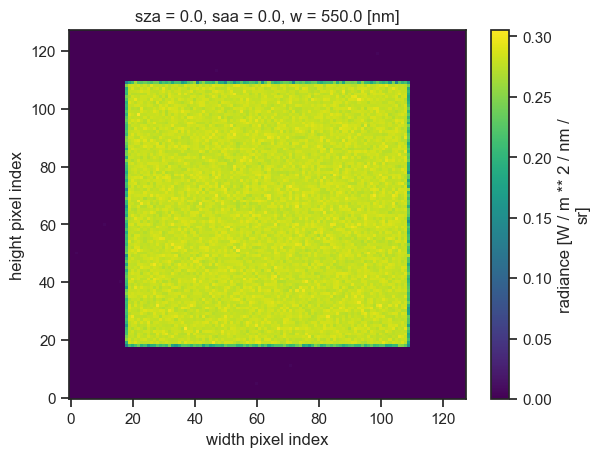

In [7]:
exp = AtmosphereExperiment(
    surface=surface,
    atmosphere=atmosphere,
    illumination=illumination,
    measures=camera,
    kdict=kdict,
)
eradiate.run(exp)["radiance"].squeeze().plot.imshow();

In [8]:
def eval_reflectance(ctx: KernelContext):
    return 1.0

In [9]:
kpmap = {
    # This key is arbitrary; we however choose to keep it consistent with
    # the expected scene parameter path.
    "01_mat_diffuse.reflectance.value": SceneParameter(
        eval_reflectance,
        # To accommodate the relative unpredictibility of the mechanism used by 
        # Mitsuba to expose its scene parameters, we have to hint Eradiate at
        # where we expect to find the parameters in the Mitsuba scene graph.
        # Here, we tell it that the parameter is expected to be held by a
        # BSDF object with ID '01_mat_checkerboard', and, relative to that
        # node, it should have the path 'reflectance.value'.
        search=SearchSceneParameter(
            node_type=mi.BSDF,
            node_id="01_mat_diffuse",
            parameter_relpath="reflectance.value",
        ),
    )
}

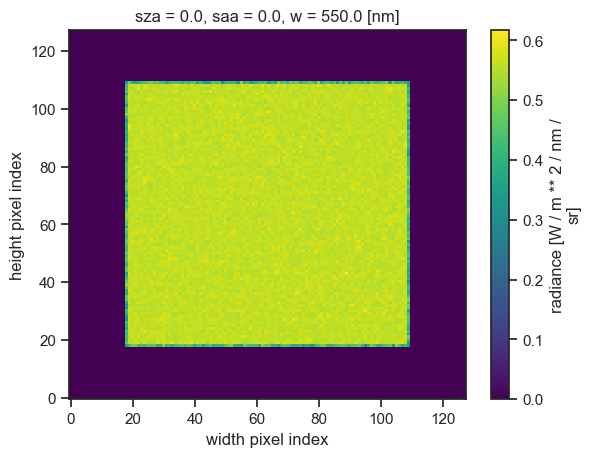

In [10]:
exp = AtmosphereExperiment(
    surface=surface,
    atmosphere=atmosphere,
    illumination=illumination,
    measures=camera,
    kdict=kdict,
    kpmap=kpmap,
)
eradiate.run(exp)["radiance"].squeeze().plot.imshow();

In [11]:
kdict={
    "01_mat_checkerboard": {
        "type": "diffuse", 
        "id": "01_mat_checkerboard",
        "reflectance": {
            # For additional information about the `bitmap` plugin,
            # see the Mitsuba documentation
            "type": "bitmap",
            "filter_type": "nearest",  # Use nearest neighbour interpolation between pixels
            "wrap_mode": "clamp",
            "raw": True,  # Do not apply colour processing
            "data": np.full((1, 1, 1), 0.5),  # Arbitrary init buffer with the right number of dimensions (3)
        },
    },
    "02_shape_checkerboard": {
        "type": "rectangle",
        "bsdf": {"type": "ref", "id": "01_mat_checkerboard"},
    },
}

In [12]:
def eval_checkerboard(ctx: KernelContext):
    value_0 = 0.2
    value_1 = 0.8
    checkerboard = np.indices((16, 16)).sum(axis=0) % 2
    return np.atleast_3d(np.where(checkerboard == 1, value_0, value_1))

kpmap = {
    "01_mat_checkerboard.reflectance.data": SceneParameter(
        eval_checkerboard,
       search=SearchSceneParameter(
            node_type=mi.BSDF,
            node_id="01_mat_checkerboard",
            parameter_relpath="reflectance.data",
        ),
    )
}

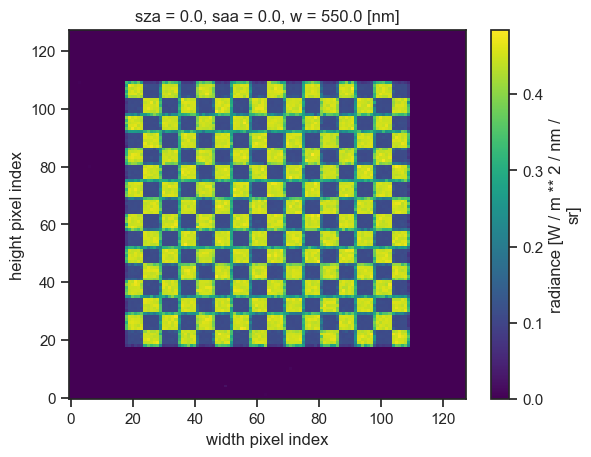

In [13]:
exp = AtmosphereExperiment(
    surface=surface,
    atmosphere=atmosphere,
    illumination=illumination,
    measures=camera,
    kdict=kdict,
    kpmap=kpmap,
)
eradiate.run(exp)["radiance"].squeeze().plot.imshow();

In [14]:
# Define colours
BLUE = {440.0: 0.9, 550.0: 0.1, 660.0: 0.1}
RED = {440.0: 0.1, 550.0: 0.1, 660.0: 0.9}

# Declare convenience functions that will evaluate colours
# based on contextual wavelength
def blue(ctx: KernelContext):
    return BLUE[ctx.si.w.m_as("nm")]


def red(ctx: KernelContext):
    return RED[ctx.si.w.m_as("nm")]

# Define a new parameter update protocol for the checkerboard
# texture that accounts for spectral dependencies
def eval_checkerboard_spectral(ctx: KernelContext):
    value_0 = blue(ctx)
    value_1 = red(ctx)
    checkerboard = np.indices((16, 16)).sum(axis=0) % 2
    return np.atleast_3d(np.where(checkerboard == 1, value_0, value_1))

# Use the new spectral checkerboard update protocol to update the
# checkerboard texture parameters
kpmap = {
    "01_mat_checkerboard.reflectance.data": SceneParameter(
        eval_checkerboard_spectral,
       search=SearchSceneParameter(
            node_type=mi.BSDF,
            node_id="01_mat_checkerboard",
            parameter_relpath="reflectance.data",
        ),
    )
}

# Update the sensor to simulate 3 wavelengths instead of 1
camera_spectral = {
    "type": "perspective",
    "origin": [0, 0, 3],
    "target": [0, 0, 0],
    "up": [0, 1, 0],
    "film_resolution": (128, 128),
    "srf": {"type": "delta", "wavelengths": [440.0, 550.0, 660.0]},
}

0/3|          | 00:00, ETA=?

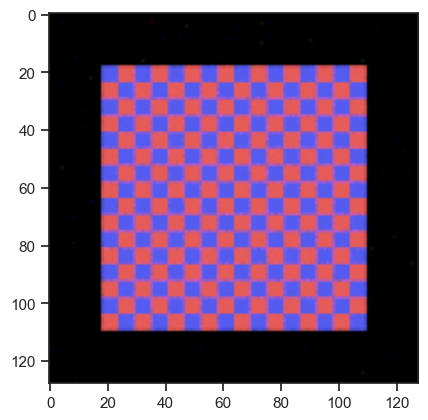

In [15]:
exp = AtmosphereExperiment(
    surface=surface,
    atmosphere=atmosphere,
    illumination=illumination,
    measures=camera_spectral,
    kdict=kdict,
    kpmap=kpmap,
)
img = dataarray_to_rgb(
    eradiate.run(exp)["radiance"],
    channels=[("w", w) for w in [660., 550., 440.]]
)
plt.imshow(img);